# Introduction
This is sample that shows how to use Datapane report for your Final Term Project. It demonstrates working with SQL databases, such as `mysql`, `duckdb`, or data warehouses like `AWS RDS`.

One of the most important skills for data analysis is interacting with databases. Most organizations store their business-critical data in a relational database like Postgres or MySQL, and you’ll need to know Structured Query Language (SQL) to access or update the data stored there.

SQL is an incredible language — it was invented in the 1970s and most new database projects e.g. Redshift, Snowflake, CockroachDB still choose it as their foundation because it is powerful and relatively simple (at least to start). And while it excels at retrieving data, you usually need an enterprise Business Intelligence platform like Tableau or Looker to visualize the results.
In this article, I’ll show you how to combine SQL and open-source Python libraries to build an interactive dashboard on the web — see a live version here, and the code on Github. This is a great technique to quickly prototype applications using a database. For more examples check this out: [Datapane github examples](https://github.com/datapane/examples)

The dataset
We’ll use a well-known open-source dataset called Park Management, which stores data about themepark management.
Here’s a quick table showing the database schema:
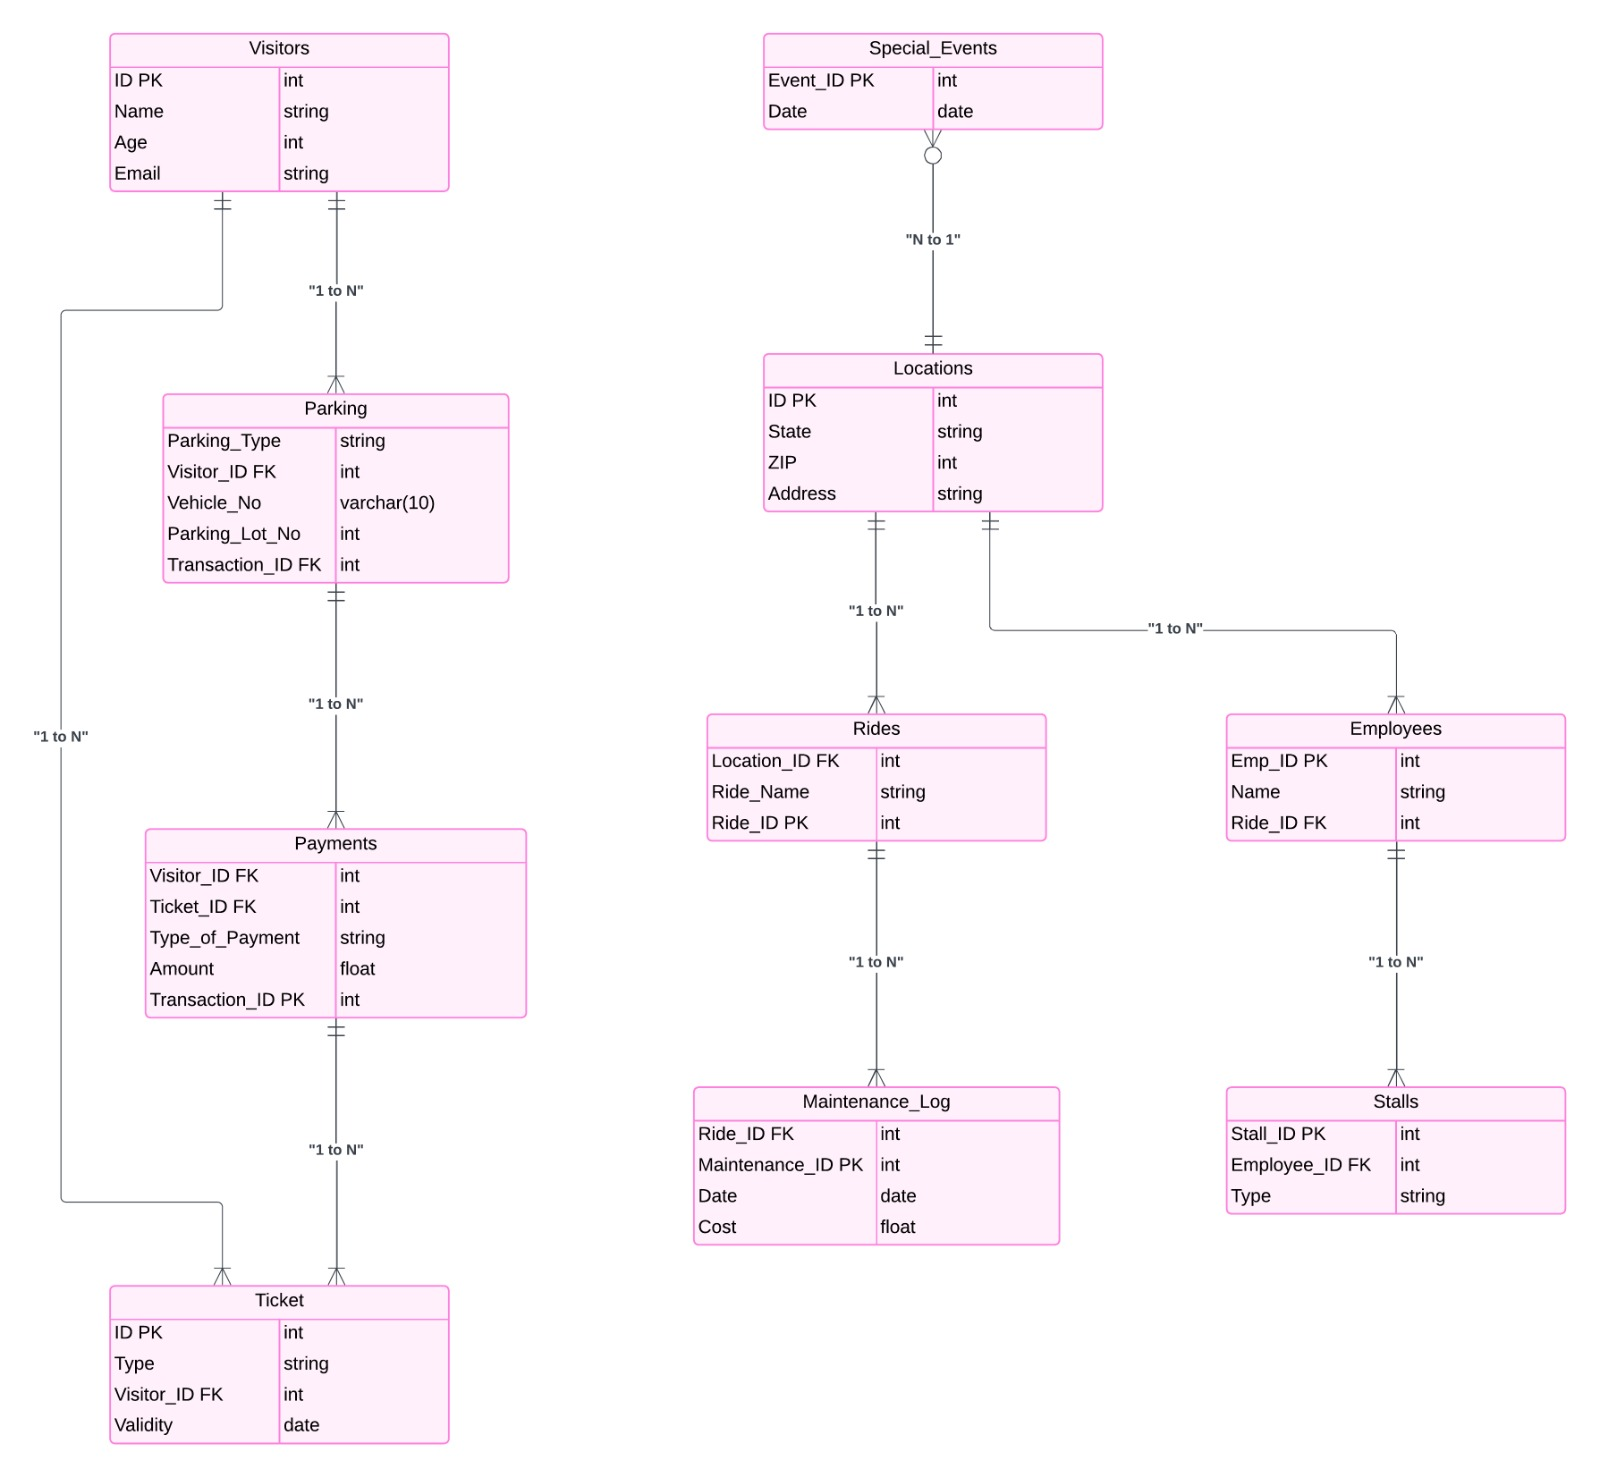

Please click here to download the database DDL file [Theme Park Management DDL](https://drive.google.com/file/d/1RLKhCHerlgbFUCBn8HYt0bspJMhSNYt0/view?usp=drive_link). You also need to use the code to implement it in the AWS RDS MySQL instance. . When we query the database, we’ll often join different tables together on their foreign keys. Connecting to the database We’ll start off by defining some helper functions for connecting to the database:

In [ ]:
import sys
!pip install pandas
!pip install numpy
!pip install datapane
!pip install plotly
!pip install pymysql

In [ ]:
# import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp
import pymysql
import warnings
import pymysql
import sys
import os

warnings.filterwarnings('ignore')



In [ ]:
host = 'database-team8mis686database.cxumao8k6yt5.us-east-2.rds.amazonaws.com'
user = 'admin'
password = 'Sdsumis686team8'
database = 'ParkManager'

connection = pymysql.connect(host=host, user=user, passwd=password, database=database)
with connection:
    cur = connection.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()
    print("Database version: {} ".format(version[0]))

Database version: 8.0.39 


In [ ]:

def run_query(q: str) -> pd.DataFrame:
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        return pd.read_sql(q, conn)


def run_command(c: str):
    with pymysql.connect(host=host, user=user, passwd=password, database=database) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [ ]:
def show_tables() -> pd.DataFrame:
    q = """
          SELECT table_name
          FROM information_schema.tables
          WHERE table_schema = 'ParkManager' AND table_type = 'BASE TABLE';
        """
    return run_query(q)


def get_table_row_count(tablename) -> int:
    q = (
        """
        SELECT
            COUNT(1)
        FROM %s;
        """
        % tablename
    )
    return run_query(q)["COUNT(1)"][0]


tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables['TABLE_NAME']]

tables

,TABLE_NAME,row_count
0,Employees,50
1,Locations,50
2,MaintenanceLog,50
3,Parking,60
4,Payments,50
5,Rides,50
6,SpecialEvents,50
7,Stalls,50
8,Tickets,50
9,Visitors,50


As you can see, we write the SQL query as a string and then execute it within a Python function. It’s a little awkward to mix two different languages together like this, but works surprisingly well once you get the hang of it! Running the code above gives all the different table names in the database and the number of rows in each table.

# Building a dashboard
Imagine you've just started as a data scientist at a theme park, and your boss wants to know which ticket types and payment methods are the most popular. To answer this question, we’ll need to write a query like this:


In [ ]:
import datapane as dp
total_sales_query = """
SELECT
    t.Type AS ticket_type,
    p.TypeOfPayment AS payment_method,
    COUNT(*) AS total_sales,
    SUM(p.Amount) AS total_revenue
FROM Tickets t
JOIN Payments p ON p.TicketID = t.TicketID
GROUP BY t.Type, p.TypeOfPayment
ORDER BY total_sales DESC;
"""

total_sales_df = run_query(total_sales_query)

dp.DataTable(total_sales_df)

We start by selecting the columns we want to see in the output. Since these come from four different tables (track, album, artist, invoice_line), we need to join the tables on the foreign key relationships — check the schema to see what is possible.

Next we group by the track name, order by the most purchases and only select the top 10 results.
Running the query gives us a pandas dataframe, which we then wrap in a DataTable block.

# More complex queries
Flush with our recent success, the boss asks us a more complex question — "Which locations are receiving the most visitors, and what type of tickets are most commonly associated with each location?" Instead of answering this question with tables, we can use a Python visualization library like Plotly to build more satisfying interactive charts:

## Selecting Albums to Purchase

We'll now calculate a few additional metrics to fill out the dashboard, like top genres

In [ ]:
# Assuming you have a function 'run_query' to execute your SQL queries and fetch results.
# Fetch the data
visitor_location_query = """
SELECT
    l.State AS location,
    t.Type AS ticket_type,
    COUNT(v.ID) AS total_visitors
FROM Visitors v
JOIN Tickets t ON v.ID = t.VisitorID
JOIN Locations l ON v.ID = t.VisitorID
GROUP BY l.State, t.Type
ORDER BY total_visitors DESC;
"""

visitor_location_df = run_query(visitor_location_query)

# Create a DataTable to show the result in a tabular format
dp.DataTable(visitor_location_df)

# Visualization: Create a bar chart showing total visitors by location and ticket type
Visitorlocationfig = px.bar(visitor_location_df,
             x='location',
             y='total_visitors',
             color='ticket_type',
             title="Visitor Distribution by Location and Ticket Type",
             labels={'total_visitors': 'Total Visitors', 'location': 'Location', 'ticket_type': 'Ticket Type'})

# Show the plot in the dashboard
dp.Plot(Visitorlocationfig)

Based on the visitor distribution across locations and ticket types, we can conclude the following:
California receives the highest number of visitors, followed by South Carolina and North Carolina. These locations should be prioritized for marketing campaigns and resource allocation to maximize engagement. Along with this, Adult Tickets dominate across all locations, accounting for the majority of visitors. This indicates that most visitors are adults, and promotions should target this demographic.

Actionable Insights:

1. Develop targeted campaigns in California to maintain its leadership in visitor numbers.
2. Enhance family-oriented activities in states with high child ticket sales, such as Florida.
3. Tailor promotions to seniors in Arizona and other states where this demographic is prominent.

## Analyzing Sales by Location

Our next task is to focus on the total sales and customer behavior in each country, helping the business understand how different locations  contribute to sales performance.


*   Total number of customers
*   Total value of sales
*   Average value of sales per customer
*   Average order value (i.e., total sales divided by the number of orders)





In [ ]:
sales_by_location = """
WITH sales_data AS (
    SELECT
        l.State AS location,
        t.Type AS ticket_type,
        COUNT(DISTINCT v.ID) AS total_customers,
        COUNT(t.TicketID) AS total_tickets_sold,
        SUM(p.Amount) AS total_sales,
        SUM(p.Amount) / COUNT(DISTINCT v.ID) AS avg_sales_per_customer
    FROM Tickets t
    JOIN Visitors v ON t.VisitorID = v.ID
    JOIN Payments p ON p.TicketID = t.TicketID
    JOIN Rides r ON r.RideID = t.TicketID  -- assuming a ride is related to ticket type
    JOIN Locations l ON r.LocationID = l.ID
    GROUP BY l.State, t.Type
)

SELECT
    location,
    ticket_type,
    total_tickets_sold,
    total_sales,
    avg_sales_per_customer
FROM sales_data
ORDER BY avg_sales_per_customer DESC;"""
run_query(sales_by_location)

,location,ticket_type,total_tickets_sold,total_sales,avg_sales_per_customer
0,Michigan,Child,1,61.00,61.000
1,Michigan,Senior,1,60.20,60.200
2,Washington,Senior,1,60.00,60.000
3,Texas,Adult,2,119.00,59.500
4,North Carolina,Child,1,59.30,59.300
5,Arizona,Senior,1,58.10,58.100
6,Pennsylvania,Child,1,57.25,57.250
7,Nevada,Child,1,57.00,57.000
8,South Carolina,Child,2,112.50,56.250
9,New York,Senior,2,105.00,52.500


## Visualizing Sales by Location

Now that we have our sales data by location, we have been asked to create a series of visualizations that effectively communicate our findings. Additionally, we need to make recommendations on which locations show the most potential for increased revenue. These insights will help guide the marketing team in planning targeted campaigns for specific locations.

In [ ]:
import plotly.express as px
import pandas as pd

# Assuming `grouped_data` is already fetched using your database query
# Replace this with the actual data retrieval code
grouped_data = pd.DataFrame({
    "location": ["California", "Michigan", "Washington", "Texas", "North Carolina", "Arizona",
                 "Pennsylvania", "Nevada", "South Carolina", "New York", "Illinois",
                 "Georgia", "Ohio", "Florida"],
    "total_sales": [271.60, 61.00, 60.00, 119.00, 59.30, 58.10, 57.25, 57.00, 112.50, 105.00,
                    102.90, 50.00, 98.50, 98.40]
})

# Create the pie chart using Plotly Express
sales_pie_chart = px.pie(
    grouped_data,
    names="location",  # The locations will be the labels on the pie chart
    values="total_sales",  # The size of each slice corresponds to the total sales
    title="Total Sales by Location"  # Title of the chart
)

# Show the chart
sales_pie_chart.show()



In [ ]:
import plotly.express as px
import pandas as pd

# Assuming `grouped_data` is already fetched using your database query
# Replace this with the actual data retrieval code
grouped_data = pd.DataFrame({
    "location": ["California", "Michigan", "Washington", "Texas", "North Carolina", "Arizona",
                 "Pennsylvania", "Nevada", "South Carolina", "New York", "Illinois",
                 "Georgia", "Ohio", "Florida"],
    "total_sales": [271.60, 61.00, 60.00, 119.00, 59.30, 58.10, 57.25, 57.00, 112.50, 105.00,
                    102.90, 50.00, 98.50, 98.40]
})

# Create the bar chart using Plotly Express
sales_bar_chart = px.bar(
    grouped_data,
    x="location",  # X-axis: location (State)
    y="total_sales",  # Y-axis: total sales
    color="location",  # Color bars by location for differentiation
    labels={"location": "Location", "total_sales": "Total Sales ($)"},  # Label customization
    title="Total Sales by Location"  # Title of the chart
)

# Customize layout (hide legend if necessary)
sales_bar_chart.update_layout(showlegend=False)

# Show the chart
sales_bar_chart.show()



How are the various stall types distributed across the park?

This can be visually represented in a bar chart, where each stall type is assigned a unique color. This analysis provides insights into the composition of stall types in the park and can help in planning resource allocation and visitor services.

In [ ]:


import plotly.express as px

# Assuming 'stall_data' is your DataFrame with columns 'StallType' and 'StallCount'
# Replace this with your actual data loading
stall_data = run_query("""
    SELECT Type, COUNT(*) AS StallCount
    FROM Stalls
    GROUP BY Type;
""")


Stalltypefig = px.bar(stall_data,
             x='Type',
             y='StallCount',
             color='Type',  # Different colors for each stall type
             title='Distribution of Stalls by Type',
             labels={'StallType': 'Stall Type', 'StallCount': 'Number of Stalls'},
             width=600,  # Adjust width as needed
             text='StallCount') # Display counts on bars

Stalltypefig.update_traces(marker_line_width=0.5) # Set the width of the bars

Stalltypefig.show()

Let us now analyze the parking data to determine the most used parking lot for each location.

In [ ]:
# Assuming the run_query function is defined already
Usage_count = """
SELECT
    P.ParkingLotNo,
    COUNT(P.VehicleNo) AS usage_count
FROM
    Parking P
JOIN
    Visitors V ON P.VisitorID = V.ID
GROUP BY
    P.ParkingLotNo
ORDER BY
    usage_count DESC;
"""

# Fetching the data
df = run_query(Usage_count)

# Visualization
import plotly.express as px
Parkingusagefig = px.bar(df, x='ParkingLotNo', y='usage_count',
             labels={'ParkingLotNo': 'Parking Lot Number', 'usage_count': 'Usage Count'},
             title='Parking Lot Usage Analysis')
Parkingusagefig.show()


Let us find out how do maintenance costs for each ride vary across different months over time?

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Example: assuming you've already connected to your database and defined run_query function

query = """
SELECT
    R.RideName,
    YEAR(M.Date) AS Year,
    MONTH(M.Date) AS Month,
    SUM(M.Cost) AS TotalMaintenanceCost
FROM
    MaintenanceLog M
JOIN
    Rides R ON M.RideID = R.RideID
GROUP BY
    R.RideName, YEAR(M.Date), MONTH(M.Date)
ORDER BY
    Year, Month, R.RideName;
"""

# Fetch data using the query
df = run_query(query)

# Check if data is returned
print(df.head())

# Create a pivot table to structure the data for the heatmap
df_pivot = df.pivot_table(index='RideName', columns=['Year', 'Month'], values='TotalMaintenanceCost', aggfunc='sum')

# Check the pivoted data
print(df_pivot)

# If data looks good, proceed with the heatmap visualization
Maintenancefig = px.imshow(df_pivot,
                labels=dict(x="Year-Month", y="Ride Name", color="Total Maintenance Cost ($)"),
                title="Maintenance Cost Heatmap Per Ride Over Time",
                color_continuous_scale="Jet")  # Change color scale here (e.g., "Jet", "Cividis", "Plasma")

Maintenancefig.show()

         RideName  Year  Month  TotalMaintenanceCost
0     Bumper Cars  2024     10               2270.65
1    Ferris Wheel  2024     10                980.90
2   Haunted House  2024     10               1155.60
3  Roller Coaster  2024     10               2226.25
4     Water Slide  2024     10                850.90
Year                         2024                       2025
Month                          10       11       12       1 
RideName                                                    
Bumper Cars               2270.65      NaN      NaN      NaN
Bungee Jump                   NaN      NaN   990.60      NaN
Carousel                      NaN  1940.30      NaN      NaN
Dragon Boat Ride              NaN      NaN  2351.65      NaN
Drop Tower                    NaN  1100.00      NaN      NaN
Drop Zone                     NaN   900.80      NaN      NaN
Ferris Wheel               980.90      NaN  1220.10      NaN
Flume Ride                    NaN      NaN      NaN  1105.75
Flying Chai

# Putting it into a Datapane report

Now that we have all our charts defined, we can combine them together into a Datapane report. We'll use Groups to add charts in a grid layout, as well as BigNumbers, Plots and DataTables.

In [ ]:
visitors = tables[tables["TABLE_NAME"] == "Visitors"]["row_count"].values[0]
employees = tables[tables["TABLE_NAME"] == "Employees"]["row_count"].values[0]
tickets_sold = tables[tables["TABLE_NAME"] == "Tickets"]["row_count"].values[0]
locations= tables[tables["TABLE_NAME"] == "Locations"]["row_count"].values[0]
total_sales_df = run_query(total_sales_query)
total_sales = total_sales_df["total_revenue"].sum()

In [ ]:
r = dp.View(
    dp.Group(
        dp.BigNumber(heading="Total visitors", value=visitors),
        dp.BigNumber(heading="Total employees", value=employees),
        dp.BigNumber(heading="Total tickets sold", value=tickets_sold),
         dp.BigNumber(heading="Total locations", value=locations),
        dp.BigNumber(heading="Total sales", value=total_sales_df["total_revenue"].sum()),
        columns=5,
        name="Little_group",
    ),
        dp.Plot(Visitorlocationfig, name="visitor_location_df"), # `name` is a valid argument to dp.Plot
    dp.Plot(sales_bar_chart),
    dp.Plot(sales_pie_chart),
     dp.Plot(Stalltypefig, name="Stalltypefig"),

    dp.Plot(Parkingusagefig, name="Parkingusagefig"),
    dp.Plot(Maintenancefig, name="Maintenancefig"),
    dp.DataTable(visitor_location_df),  # Removed `name="visitor_location_df"`
    dp.DataTable(total_sales_df),  # Removed `name="total_sales_df"`




)

dp.save_report(r, "report.html", open=True)


App saved to ./report.html

In [ ]:
import IPython
IPython.display.HTML(filename='report.html')